**Task - 2**

**3. Loan Approval Prediction with Machine Learning using Python**
Problem Statement: Loan Approval Prediction poses a critical
challenge in the fintech sector, necessitating the application of
Machine Learning to analyze credit history data and construct
intelligent systems capable of making informed decisions about loan
approvals. This problem involves delving into various factors such as
the applicant's financial history, income, credit rating, employment
status, and other pertinent attributes.

**Solution:**

The algorithm used here is XGBoost (Extreme Gradient Boosting), a powerful machine learning method based on decision trees.
It works by building a series of trees where each tree tries to correct the errors made by the previous ones.
XGBoost combines these trees to make accurate predictions.
It is highly efficient, handles missing data well, and often performs better than other algorithms on structured/tabular data.


✅ Accuracy: 0.8455

✅ Confusion Matrix:
[[21 17]
 [ 2 83]]

✅ Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.55      0.69        38
           1       0.83      0.98      0.90        85

    accuracy                           0.85       123
   macro avg       0.87      0.76      0.79       123
weighted avg       0.86      0.85      0.83       123


📊 Cross-Validated Accuracy: 0.8045


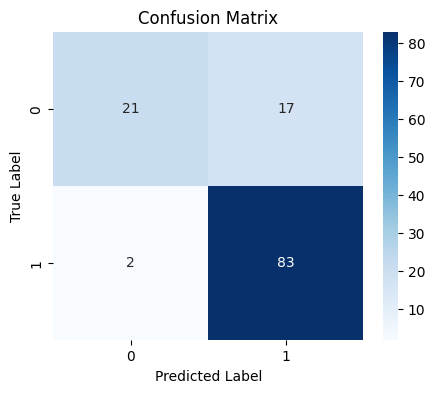

<Figure size 1000x600 with 0 Axes>

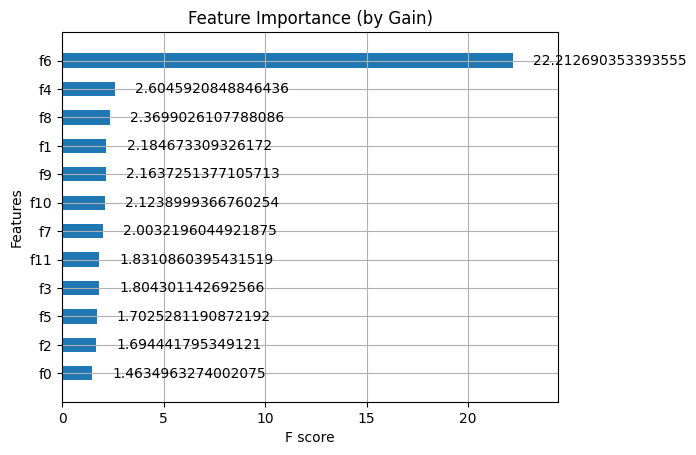

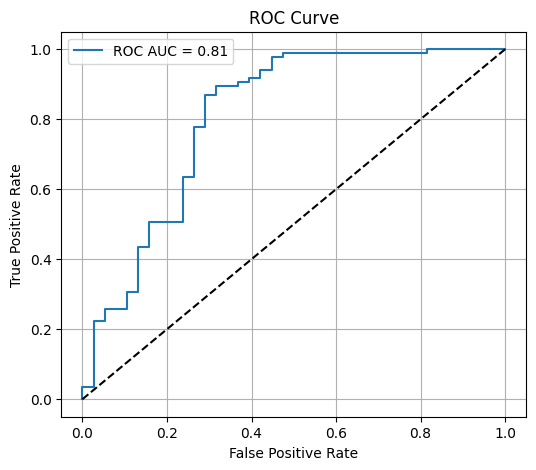

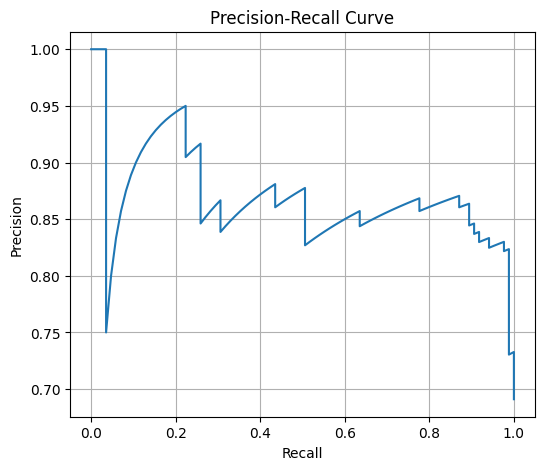

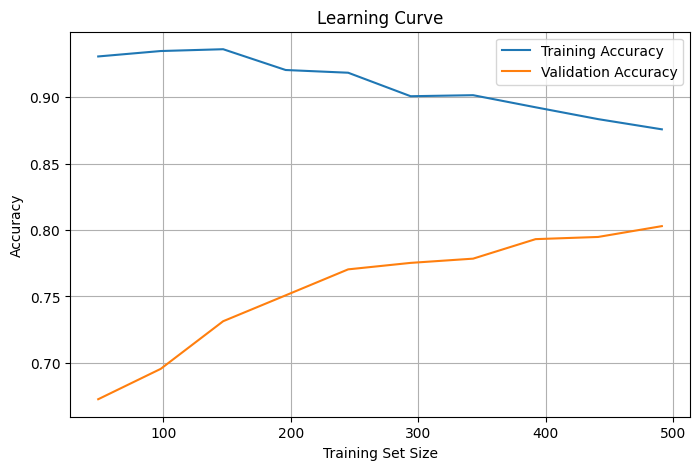

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve
)
from xgboost import XGBClassifier, plot_importance
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("loan_prediction.csv")
df.drop("Loan_ID", axis=1, inplace=True)
df['Dependents'] = df['Dependents'].replace('3+', 3).astype(float)

# Fill missing values
fill_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History', 'Loan_Amount_Term']
for col in fill_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())


df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['Log_Income'] = np.log1p(df['Total_Income'])
df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']
df['Balance_Income'] = df['Total_Income'] - df['EMI'] * 1000
df['LoanAmount_log'] = np.log1p(df['LoanAmount'])
df.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Total_Income'], axis=1, inplace=True)

le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


xgb_final = XGBClassifier(
    n_estimators=250,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=1,
    eval_metric="logloss",
    early_stopping_rounds=10,
    use_label_encoder=False,
    random_state=42
)

xgb_final.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred = xgb_final.predict(X_test)
y_proba = xgb_final.predict_proba(X_test)[:, 1]

print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n✅ Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"\n✅ Classification Report:\n{classification_report(y_test, y_pred)}")

xgb_cv = XGBClassifier(
    n_estimators=250,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=1,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_cv, X_scaled, y, cv=cv, scoring='accuracy')
print(f"\n📊 Cross-Validated Accuracy: {cv_scores.mean():.4f}")



# 🔷 1. Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 🔷 2. Feature Importance (Gain)
plt.figure(figsize=(10, 6))
plot_importance(xgb_final, importance_type='gain', height=0.5)
plt.title("Feature Importance (by Gain)")
plt.show()

# 🔷 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 🔷 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

# 🔷 5. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    xgb_cv, X_scaled, y, cv=cv, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, val_mean, label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

**Output :**

The model achieved 84.55% accuracy on the test data, correctly predicting most loan approvals. The confusion matrix shows it predicted class 1 (loan approved) very well but struggled with class 0 (loan not approved), leading to a lower recall for class 0 (55%). The classification report confirms this imbalance, with a strong overall f1-score of 0.83. The cross-validated accuracy (80.45%) suggests the model performs consistently across different data splits.